In [1]:
import torch

In [2]:
GPU_NUM = 0
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU
# print ('Current cuda device ', torch.cuda.current_device()) # check

# # Additional Infos
# if device.type == 'cuda':
#     print(torch.cuda.get_device_name(GPU_NUM))
#     print('Memory Usage:')
#     print('Allocated:', round(torch.cuda.memory_allocated(GPU_NUM)/1024**3,1), 'GB')
#     print('Cached:   ', round(torch.cuda.memory_cached(GPU_NUM)/1024**3,1), 'GB')

Current cuda device  2
GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [3]:
from load_data import *

In [4]:
Xtr, Xte, ytr, yte, Ztr, Zte = load_german_data()
ytr = ytr.astype('float32').reshape((-1,1))
yte = yte.astype('float32').reshape((-1,1))

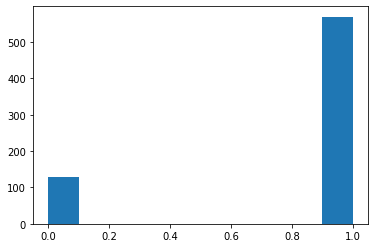

In [5]:
import matplotlib.pyplot as plt
plt.hist(Ztr[:,0])
plt.show()

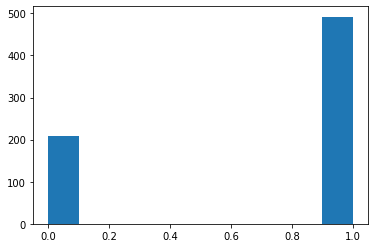

In [6]:
plt.hist(ytr)
plt.show()

In [7]:
sum(Ztr==0)/len(Ztr)

array([0.18571429])

In [8]:
print('# training samples:', Xtr.shape)
print('# test samples:', Xte.shape)
print('# sensitive vars', Ztr.shape)


# training samples: (700, 23)
# test samples: (300, 23)
# sensitive vars (700, 1)


In [9]:
N1 = 100
Xtr1 = Xtr[:N1]
ytr1 = ytr[:N1]
Ztr1 = Ztr[:N1]
Xtr2 = Xtr[N1:]
ytr2 = ytr[N1:]
Ztr2 = Ztr[N1:]

In [10]:
np.unique(Ztr)

array([0., 1.])

In [11]:
Ztr.shape

(700, 1)

In [12]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [13]:
from fairNN_train import *
from load_data import *

In [14]:
class Args:
    def __init__(self):
        self.epochs = 30
        self.AL_iters = 10
        self.AL_batch = 32
        self.batch_size = 32
        self.AL_select = 'loss'
        
    def print_args(self):
        print("train epochs/batch: {}/{}".format(self.epochs,self.batch_size))
        print("AL iters/batch: {}/{}".format(self.AL_iters,self.AL_batch))
        print("AL selection is based on ", self.AL_select)

In [15]:
args = Args()

In [16]:
train_data = NPsDataSet(Xtr1, ytr1, Ztr1)
train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True, drop_last=True)

In [17]:
from fair_eval import *

In [18]:
zZtr2 = transform_dum2cat(Ztr2)
select_data = NPsDataSet(Xtr2, ytr2, zZtr2)
select_loader = DataLoader(select_data, batch_size=args.batch_size, shuffle=False, drop_last=False)

In [19]:
test_data = NPsDataSet(Xte, yte, Zte)
test_loader = DataLoader(test_data, batch_size=args.batch_size, shuffle=False, drop_last=False)

- gradient calculation for unlabeled set
- expectation 
- https://discuss.pytorch.org/t/how-to-efficiently-compute-gradient-for-each-training-sample/60001/2 
- https://github.com/cybertronai/autograd-hacks#per-example-gradients 
- https://tutorials.pytorch.kr/intermediate/tensorboard_tutorial.html

# Group Selection Part

## Test Group Performance

## find examples for the worst group

In [20]:
from fairAL_utils import *

## retraining models

In [21]:
def train_AL(train_loader, select_loader, device, args = None, test_loader = None, from_scratch = False):
    if args is None:
        args = Args()
    print("arguments: ", args.print_args())
    n_features = train_loader.dataset.tensors[0].shape[1]
    if from_scratch == False:
        clf = Classifier(n_features=n_features)
        clf_criterion = nn.BCELoss()
        clf_optimizer = optim.Adam(clf.parameters())
    
    assert((args.AL_iters-1)*args.AL_batch<select_loader.dataset.tensors[0].shape[0])
    for it in range(args.AL_iters):
        if from_scratch:
            clf = Classifier(n_features=n_features)
            clf_criterion = nn.BCELoss()
            clf_optimizer = optim.Adam(clf.parameters())
        clf.cuda()
        train_model(clf, train_loader, clf_criterion, clf_optimizer, device, args, test_loader)
        trTensors = train_loader.dataset.tensors
        dldic = divide_groupsDL(trTensors[0],trTensors[1],trTensors[2])
        losss = 0
        accs = 0
        sid = list(dldic.keys())[0]
        for did in dldic.keys():
            loss_v, acc_v = test_model_noz(clf, dldic[did],clf_criterion, device)
            print("{} : loss {} / acc {}".format(did, loss_v, acc_v))
            if args.AL_select == 'loss':
                if losss > loss_v:
                    sid = did
            else:
                assert args.AL_select == 'acc'
                if accs < acc_v:
                    sid = did
        if it <args.AL_iters-1:
            grads = cal_meangrad(clf, dldic[sid], clf_criterion, device)
            ses,sidx = select_examples(clf, select_loader, clf_criterion, grads,device, args.AL_batch)
#             print(ses)
            train_loader, select_loader = obtain_newDS(train_loader, select_loader, ses, sidx, args.batch_size)
    return clf    

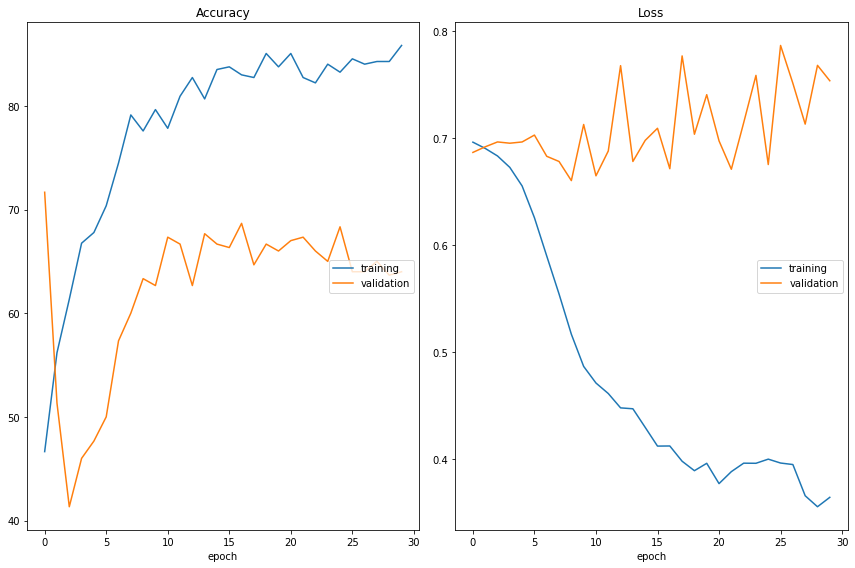

Accuracy
	training         	 (min:   46.649, max:   85.825, cur:   85.825)
	validation       	 (min:   41.333, max:   71.667, cur:   64.000)
Loss
	training         	 (min:    0.356, max:    0.696, cur:    0.365)
	validation       	 (min:    0.660, max:    0.786, cur:    0.753)
Finished Training
0.0 : loss 0.3113325238227844 / acc 90.24390411376953
1.0 : loss 0.3378344178199768 / acc 87.90849304199219


Classifier(
  (network): Sequential(
    (0): Linear(in_features=23, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [23]:
train_AL(train_loader, select_loader, device, args, test_loader, from_scratch = True)

[0.0, 1.0]